In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import sccellfie
import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import requests

from pathlib import Path
import os

In [4]:
base_dir = Path().resolve()
parent_dir = base_dir.parent
parent_dir

PosixPath('/home/sadegh/projects/nanostring-cosmx-spatial-omics-modeling')

## Read Data

In [5]:
# mean_cell_gene_removed_normalized or 
adata = sc.read(filename=parent_dir / 'data/h5ad/filtered_normalized_data.h5ad')
adata

AnnData object with n_obs × n_vars = 174747 × 1011
    obs: 'nCount_Nanostring', 'nFeature_Nanostring', 'cell_ID', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68', 'Max.CD68', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'id', 'TMA', 'Subject_ID', 'Treatment_Status', 'Run_Tissue_name', 'log10totalcounts', 'cell_type', 'tissue', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    obsm: 'spatial'

In [6]:
adata.var_names = adata.var["gene"].astype(str)
adata.var_names_make_unique()

### Compute Fluxomic (reaction/metabolic tasks) Data from Spatial Transcriptomic using scCellFie

In [7]:
results = sccellfie.run_sccellfie_pipeline(adata,
                                           organism='human',
                                           sccellfie_data_folder=None,
                                           n_counts_col='nCount_Nanostring',
                                           process_by_group=False,
                                           groupby=None, # 'Treatment_Status' or None
                                           neighbors_key='neighbors',
                                           n_neighbors=10,
                                           batch_key='sample',
                                           threshold_key='sccellfie_threshold',
                                           smooth_cells=True,
                                           alpha=0.33,
                                           chunk_size=5000,
                                           disable_pbar=True,
                                           save_folder=None, # 'result or None',
                                           save_filename=None, # 'sccellfie_results or None'
                                          )


==== scCellFie Pipeline: Initializing ====
Loading scCellFie database for organism: human

==== scCellFie Pipeline: Processing entire dataset ====

---- scCellFie Step: Preprocessing data ----

---- scCellFie Step: Computing neighbors ----

---- scCellFie Step: Preparing inputs ----
Gene names corrected to match database: 22
Shape of new adata object: (174747, 26)
Number of GPRs: 81
Shape of tasks by genes: (107, 26)
Shape of reactions by genes: (81, 26)
Shape of tasks by reactions: (107, 81)

---- scCellFie Step: Smoothing gene expression ----

---- scCellFie Step: Computing gene scores ----

---- scCellFie Step: Computing reaction activity ----

---- scCellFie Step: Computing metabolic task activity ----
Removed 7 metabolic tasks with zeros across all cells.

==== scCellFie Pipeline: Processing completed successfully ====


In [8]:
adata_main = results['adata']
adata_main

AnnData object with n_obs × n_vars = 174747 × 26
    obs: 'nCount_Nanostring', 'nFeature_Nanostring', 'cell_ID', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68', 'Max.CD68', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'id', 'TMA', 'Subject_ID', 'Treatment_Status', 'Run_Tissue_name', 'log10totalcounts', 'cell_type', 'tissue', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'normalization', 'neighbors', 'umap'
    obsm: 'spatial', 'X_pca', 'X_umap'
    layers: 'counts', 'smoothed_X', 'gene_scores'
    obsp: 'distances', 'c

### Masking treated and untreated cells

In [9]:
# Treated
mask_treated = adata_main.obs["Treatment_Status"] == "Treated"
adata_treated = adata_main[mask_treated]
adata_treated.reactions = adata_main.reactions[mask_treated]
adata_treated.metabolic_tasks = adata_main.metabolic_tasks[mask_treated]
adata_treated.varm.clear()

# Untreated
mask_untreated = adata_main.obs["Treatment_Status"] == "Untreated"
adata_untreated = adata_main[mask_untreated]
adata_untreated.reactions = adata_main.reactions[mask_untreated]
adata_untreated.metabolic_tasks = adata_main.metabolic_tasks[mask_untreated]
adata_untreated.varm.clear()

### Add gene expression data and metabolic task scores to AnnData object

In [10]:
adata_treated_gene_metabolic_task = sccellfie.preprocessing.adata_utils.transfer_variables(
    adata_target=adata_treated,                                   
    adata_source= adata_treated.metabolic_tasks,       
    var_names=adata_treated.metabolic_tasks.var_names  
)
adata_treated_gene_metabolic_task

AnnData object with n_obs × n_vars = 69216 × 126
    obs: 'nCount_Nanostring', 'nFeature_Nanostring', 'cell_ID', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68', 'Max.CD68', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'id', 'TMA', 'Subject_ID', 'Treatment_Status', 'Run_Tissue_name', 'log10totalcounts', 'cell_type', 'tissue', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    uns: 'normalization', 'neighbors', 'umap'
    obsm: 'spatial', 'X_pca', 'X_umap'
    layers: 'counts', 'smoothed_X', 'gene_scores'
    obsp: 'distances', 'connectivities'

In [11]:
adata_untreated_gene_metabolic_task = sccellfie.preprocessing.adata_utils.transfer_variables(
    adata_target=adata_untreated,                                   
    adata_source= adata_untreated.metabolic_tasks,       
    var_names=adata_untreated.metabolic_tasks.var_names  
)
adata_untreated_gene_metabolic_task

AnnData object with n_obs × n_vars = 105531 × 126
    obs: 'nCount_Nanostring', 'nFeature_Nanostring', 'cell_ID', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68', 'Max.CD68', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'id', 'TMA', 'Subject_ID', 'Treatment_Status', 'Run_Tissue_name', 'log10totalcounts', 'cell_type', 'tissue', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    uns: 'normalization', 'neighbors', 'umap'
    obsm: 'spatial', 'X_pca', 'X_umap'
    layers: 'counts', 'smoothed_X', 'gene_scores'
    obsp: 'distances', 'connectivities'

## Single-Cell Cell-Cell Communication Analysis

### Preparing Ligand Receptor Data

In [12]:
dataset_gene_name = list(adata_main.var_names)
dataset_gene_name

['ACACB',
 'ARF1',
 'ARG1',
 'ATP5F1E',
 'B3GNT7',
 'CALM1',
 'CYP1B1',
 'CYP2U1',
 'DDC',
 'ENO1',
 'FASN',
 'G6PD',
 'GLUD1',
 'GLUL',
 'GPX1',
 'HSD17B2',
 'HSP90B1',
 'IDO1',
 'KYNU',
 'LDHA',
 'PTGS1',
 'PTGS2',
 'SEC61G',
 'ST6GAL1',
 'TP53',
 'TYMS']

In [13]:
task_by_genes = pd.read_csv("Task_by_Gene.csv")
task_by_genes['genes'] = task_by_genes.apply(lambda row: list(task_by_genes.columns[row == 1]), axis=1)
task_by_genes["Intersection_genes"] = task_by_genes["genes"].apply(lambda x: list(set(x) & set(dataset_gene_name)))
task_intersect_df = task_by_genes[["Task","Intersection_genes"]]
task_intersect_df

,Task,Intersection_genes
0,(R)-3-Hydroxybutanoate synthesis,[ENO1]
1,3'-Phospho-5'-adenylyl sulfate synthesis,[]
2,AMP salvage from adenine,[]
3,ATP generation from glucose (hypoxic condition...,[ENO1]
4,ATP regeneration from glucose (normoxic condit...,"[LDHA, ENO1, ATP5F1E]"
...,...,...
213,cis-vaccenic acid synthesis,"[ACACB, LDHA, FASN, ENO1]"
214,gamma-Linolenate degradation,"[GPX1, LDHA]"
215,gamma-Linolenate synthesis,[]
216,glyco-cholate synthesis,[]


In [14]:
all_genes = [g for sublist in task_by_genes["Intersection_genes"] for g in sublist]
unique_genes = sorted(set(all_genes))
unique_genes

['ACACB',
 'ARF1',
 'ARG1',
 'ATP5F1E',
 'B3GNT7',
 'CALM1',
 'CYP1B1',
 'CYP2U1',
 'DDC',
 'ENO1',
 'FASN',
 'G6PD',
 'GLUD1',
 'GLUL',
 'GPX1',
 'HSD17B2',
 'HSP90B1',
 'IDO1',
 'KYNU',
 'LDHA',
 'PTGS1',
 'PTGS2',
 'SEC61G',
 'ST6GAL1',
 'TP53',
 'TYMS']

### Finding Gene Categories for Using in receptor-ligand analysis

In [15]:
def classify_gene(gene_symbol):
    url = f"http://mygene.info/v3/query?q=symbol:{gene_symbol}&species=human&fields=go"
    r = requests.get(url).json()
    if "hits" not in r or len(r["hits"]) == 0:
        return "unknown"
    
    go_terms = []
    for h in r["hits"]:
        if "go" in h:
            for k in h["go"]:
                entries = h["go"][k]
                if isinstance(entries, list):
                    go_terms.extend([e["term"].lower() for e in entries if "term" in e])
                elif isinstance(entries, dict):
                    go_terms.append(entries.get("term","").lower())
    
    if any("catalytic activity" in t or "enzyme" in t for t in go_terms):
        return "enzyme"
    if any("receptor activity" in t or "signaling receptor" in t for t in go_terms):
        return "receptor"
    if any("transporter activity" in t or "channel activity" in t for t in go_terms):
        return "transporter"
    
    return "other"

In [16]:
results_file = "Gene_categories.csv"

if os.path.exists(results_file):
    print("✅ Gene_categories.csv found — loading existing file...")
    res_df = pd.read_csv(results_file)

else:
    print("🔍 File not found — classifying genes and creating new file...")
    results = []

    for g in unique_genes:
        cat = classify_gene(g)
        results.append({"Gene": g, "Category": cat})

    res_df = pd.DataFrame(results)
    res_df.to_csv(results_file, index=False)
    print(f"💾 File saved as {results_file}")

res_df.head()

✅ Gene_categories.csv found — loading existing file...


,Gene,Category
0,ACACB,enzyme
1,ARF1,other
2,ARG1,other
3,ATP5F1E,other
4,B3GNT7,other


In [17]:
task_exploded = task_intersect_df.explode("Intersection_genes")
task_exploded.dropna(inplace=True)
task_exploded

,Task,Intersection_genes
0,(R)-3-Hydroxybutanoate synthesis,ENO1
3,ATP generation from glucose (hypoxic condition...,ENO1
4,ATP regeneration from glucose (normoxic condit...,LDHA
4,ATP regeneration from glucose (normoxic condit...,ENO1
4,ATP regeneration from glucose (normoxic condit...,ATP5F1E
...,...,...
213,cis-vaccenic acid synthesis,LDHA
213,cis-vaccenic acid synthesis,FASN
213,cis-vaccenic acid synthesis,ENO1
214,gamma-Linolenate degradation,GPX1


In [18]:
# Just transporters or enzymes
transporters_enzymes = res_df[(res_df["Category"] == "transporter") | (res_df["Category"] == "enzyme")]["Gene"]
dataset_tasks_list = adata_main.metabolic_tasks.var_names
final_task_genes = task_exploded[task_exploded["Intersection_genes"].isin(transporters_enzymes)]
final_task_genes = task_exploded[task_exploded["Task"].isin(dataset_tasks_list)]
final_task_genes

,Task,Intersection_genes
0,(R)-3-Hydroxybutanoate synthesis,ENO1
3,ATP generation from glucose (hypoxic condition...,ENO1
4,ATP regeneration from glucose (normoxic condit...,LDHA
4,ATP regeneration from glucose (normoxic condit...,ENO1
4,ATP regeneration from glucose (normoxic condit...,ATP5F1E
...,...,...
213,cis-vaccenic acid synthesis,LDHA
213,cis-vaccenic acid synthesis,FASN
213,cis-vaccenic acid synthesis,ENO1
214,gamma-Linolenate degradation,GPX1


In [19]:
lr_pairs = list(final_task_genes.itertuples(index=False, name=None))
lr_pairs

[('(R)-3-Hydroxybutanoate synthesis', 'ENO1'),
 ('ATP generation from glucose (hypoxic conditions) - glycolysis', 'ENO1'),
 ('ATP regeneration from glucose (normoxic conditions) - glycolysis + krebs cycle',
  'LDHA'),
 ('ATP regeneration from glucose (normoxic conditions) - glycolysis + krebs cycle',
  'ENO1'),
 ('ATP regeneration from glucose (normoxic conditions) - glycolysis + krebs cycle',
  'ATP5F1E'),
 ('Acetoacetate synthesis', 'ENO1'),
 ('Alanine degradation', 'GLUL'),
 ('Alanine degradation', 'LDHA'),
 ('Alanine degradation', 'GLUD1'),
 ('Alanine degradation', 'ENO1'),
 ('Alanine synthesis', 'ENO1'),
 ('Arachidonate degradation', 'LDHA'),
 ('Arachidonate synthesis', 'ACACB'),
 ('Arachidonate synthesis', 'LDHA'),
 ('Arachidonate synthesis', 'ENO1'),
 ('Arginine degradation', 'GLUL'),
 ('Arginine degradation', 'ARG1'),
 ('Arginine degradation', 'ENO1'),
 ('Arginine degradation', 'ATP5F1E'),
 ('Arginine synthesis', 'ENO1'),
 ('Asparagine degradation', 'GLUL'),
 ('Asparagine degra

### Cell-Cell Communication Analysis

In [20]:
ccc_adata_treated = sccellfie.communication.compute_communication_scores(
    adata_treated_gene_metabolic_task,
    var_pairs=lr_pairs,
    groupby='cell_type',
    communication_score='gmean',
    agg_func='trimean',
    ligand_threshold=0.1, 
    receptor_threshold=0
)
ccc_adata_treated

,sender_celltype,receiver_celltype,ligand,receptor,score,ligand_fraction,receptor_fraction
0,Adult.Glia,Adult.Glia,(R)-3-Hydroxybutanoate synthesis,ENO1,93.227896,1.0,1.000000
1,Adult.Glia,Adult.Glia,ATP generation from glucose (hypoxic condition...,ENO1,93.227896,1.0,1.000000
2,Adult.Glia,Adult.Glia,ATP regeneration from glucose (normoxic condit...,LDHA,65.047241,1.0,1.000000
3,Adult.Glia,Adult.Glia,ATP regeneration from glucose (normoxic condit...,ENO1,60.350403,1.0,1.000000
4,Adult.Glia,Adult.Glia,ATP regeneration from glucose (normoxic condit...,ATP5F1E,59.800456,1.0,1.000000
...,...,...,...,...,...,...,...
358951,venous.capillary,venous.capillary,cis-vaccenic acid synthesis,LDHA,31.021047,1.0,1.000000
358952,venous.capillary,venous.capillary,cis-vaccenic acid synthesis,FASN,9.800150,1.0,0.923858
358953,venous.capillary,venous.capillary,cis-vaccenic acid synthesis,ENO1,36.693763,1.0,1.000000
358954,venous.capillary,venous.capillary,gamma-Linolenate degradation,GPX1,74.481548,1.0,1.000000


In [21]:
ccc_adata_untreated = sccellfie.communication.compute_communication_scores(
    adata_untreated_gene_metabolic_task,
    var_pairs=lr_pairs,
    groupby='cell_type',
    communication_score='gmean',
    agg_func='trimean',
    ligand_threshold=0.1, 
    receptor_threshold=0
)
ccc_adata_untreated

,sender_celltype,receiver_celltype,ligand,receptor,score,ligand_fraction,receptor_fraction
0,Adult.Glia,Adult.Glia,(R)-3-Hydroxybutanoate synthesis,ENO1,111.662446,1.0,1.000000
1,Adult.Glia,Adult.Glia,ATP generation from glucose (hypoxic condition...,ENO1,111.662446,1.0,1.000000
2,Adult.Glia,Adult.Glia,ATP regeneration from glucose (normoxic condit...,LDHA,77.010981,1.0,1.000000
3,Adult.Glia,Adult.Glia,ATP regeneration from glucose (normoxic condit...,ENO1,71.946590,1.0,1.000000
4,Adult.Glia,Adult.Glia,ATP regeneration from glucose (normoxic condit...,ATP5F1E,56.872125,1.0,1.000000
...,...,...,...,...,...,...,...
340779,venous.capillary,venous.capillary,cis-vaccenic acid synthesis,LDHA,27.848778,1.0,1.000000
340780,venous.capillary,venous.capillary,cis-vaccenic acid synthesis,FASN,8.180808,1.0,0.904645
340781,venous.capillary,venous.capillary,cis-vaccenic acid synthesis,ENO1,34.522669,1.0,1.000000
340782,venous.capillary,venous.capillary,gamma-Linolenate degradation,GPX1,67.900786,1.0,1.000000


### Visualization of the cell-cell communication results

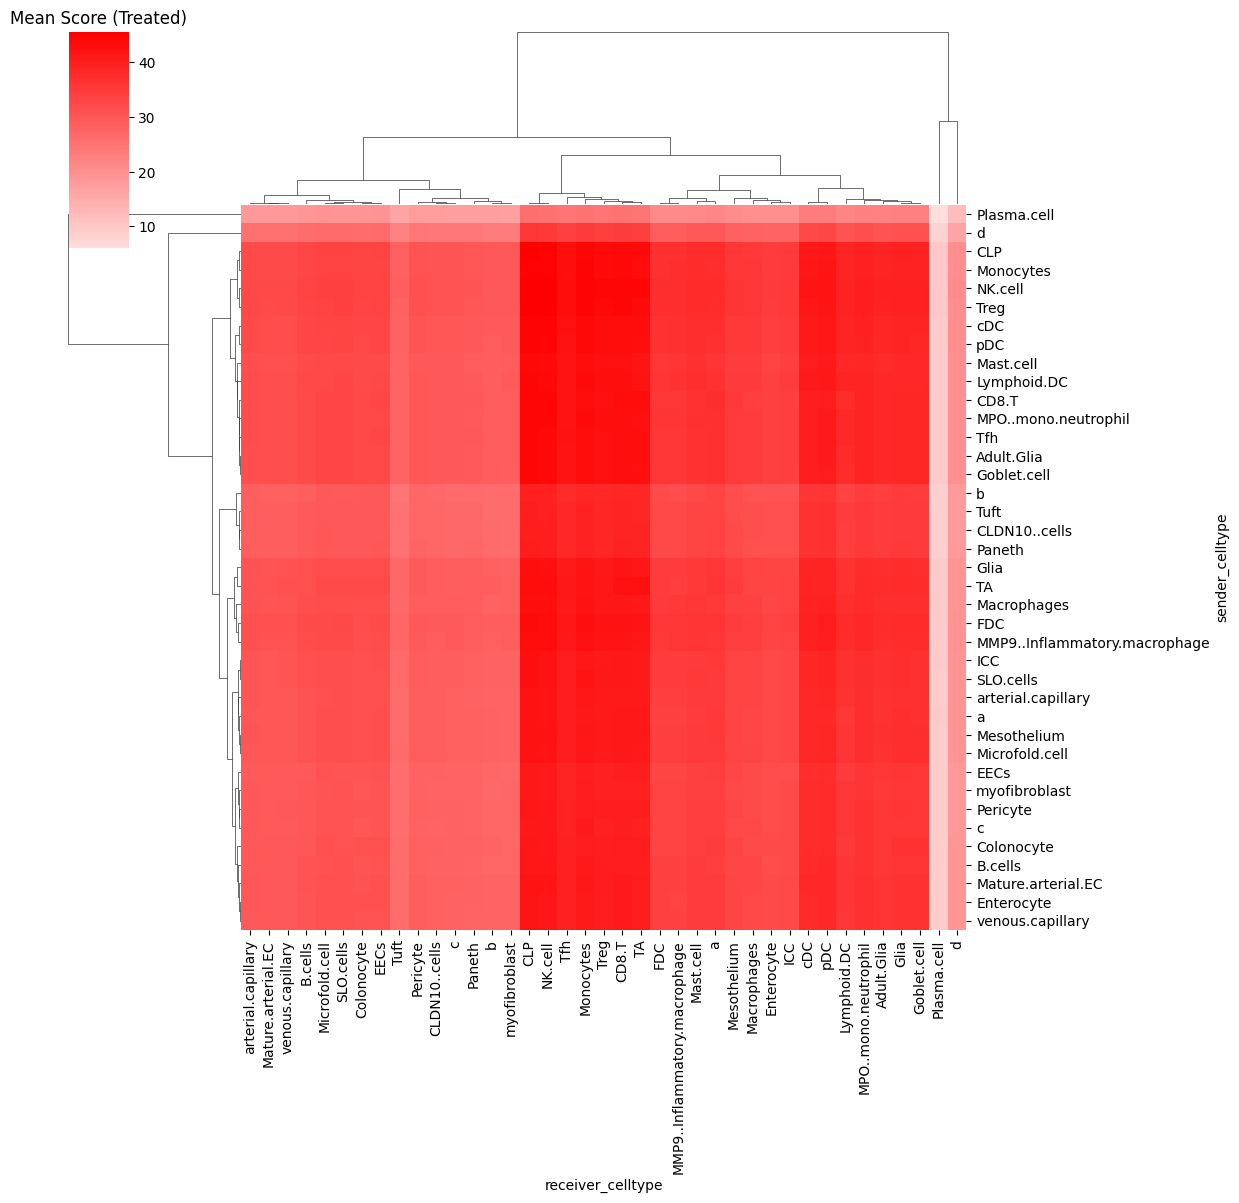

In [22]:
tmp = ccc_adata_treated.groupby(["sender_celltype", "receiver_celltype"])["score"].mean().reset_index()

pivot = tmp.pivot(index="sender_celltype", columns="receiver_celltype", values="score")

sns.clustermap(
    pivot,
    cmap="bwr",
    center=0,
    annot=False,
    figsize=(12, 12)
)

plt.title("Mean Score (Treated)")
plt.show()

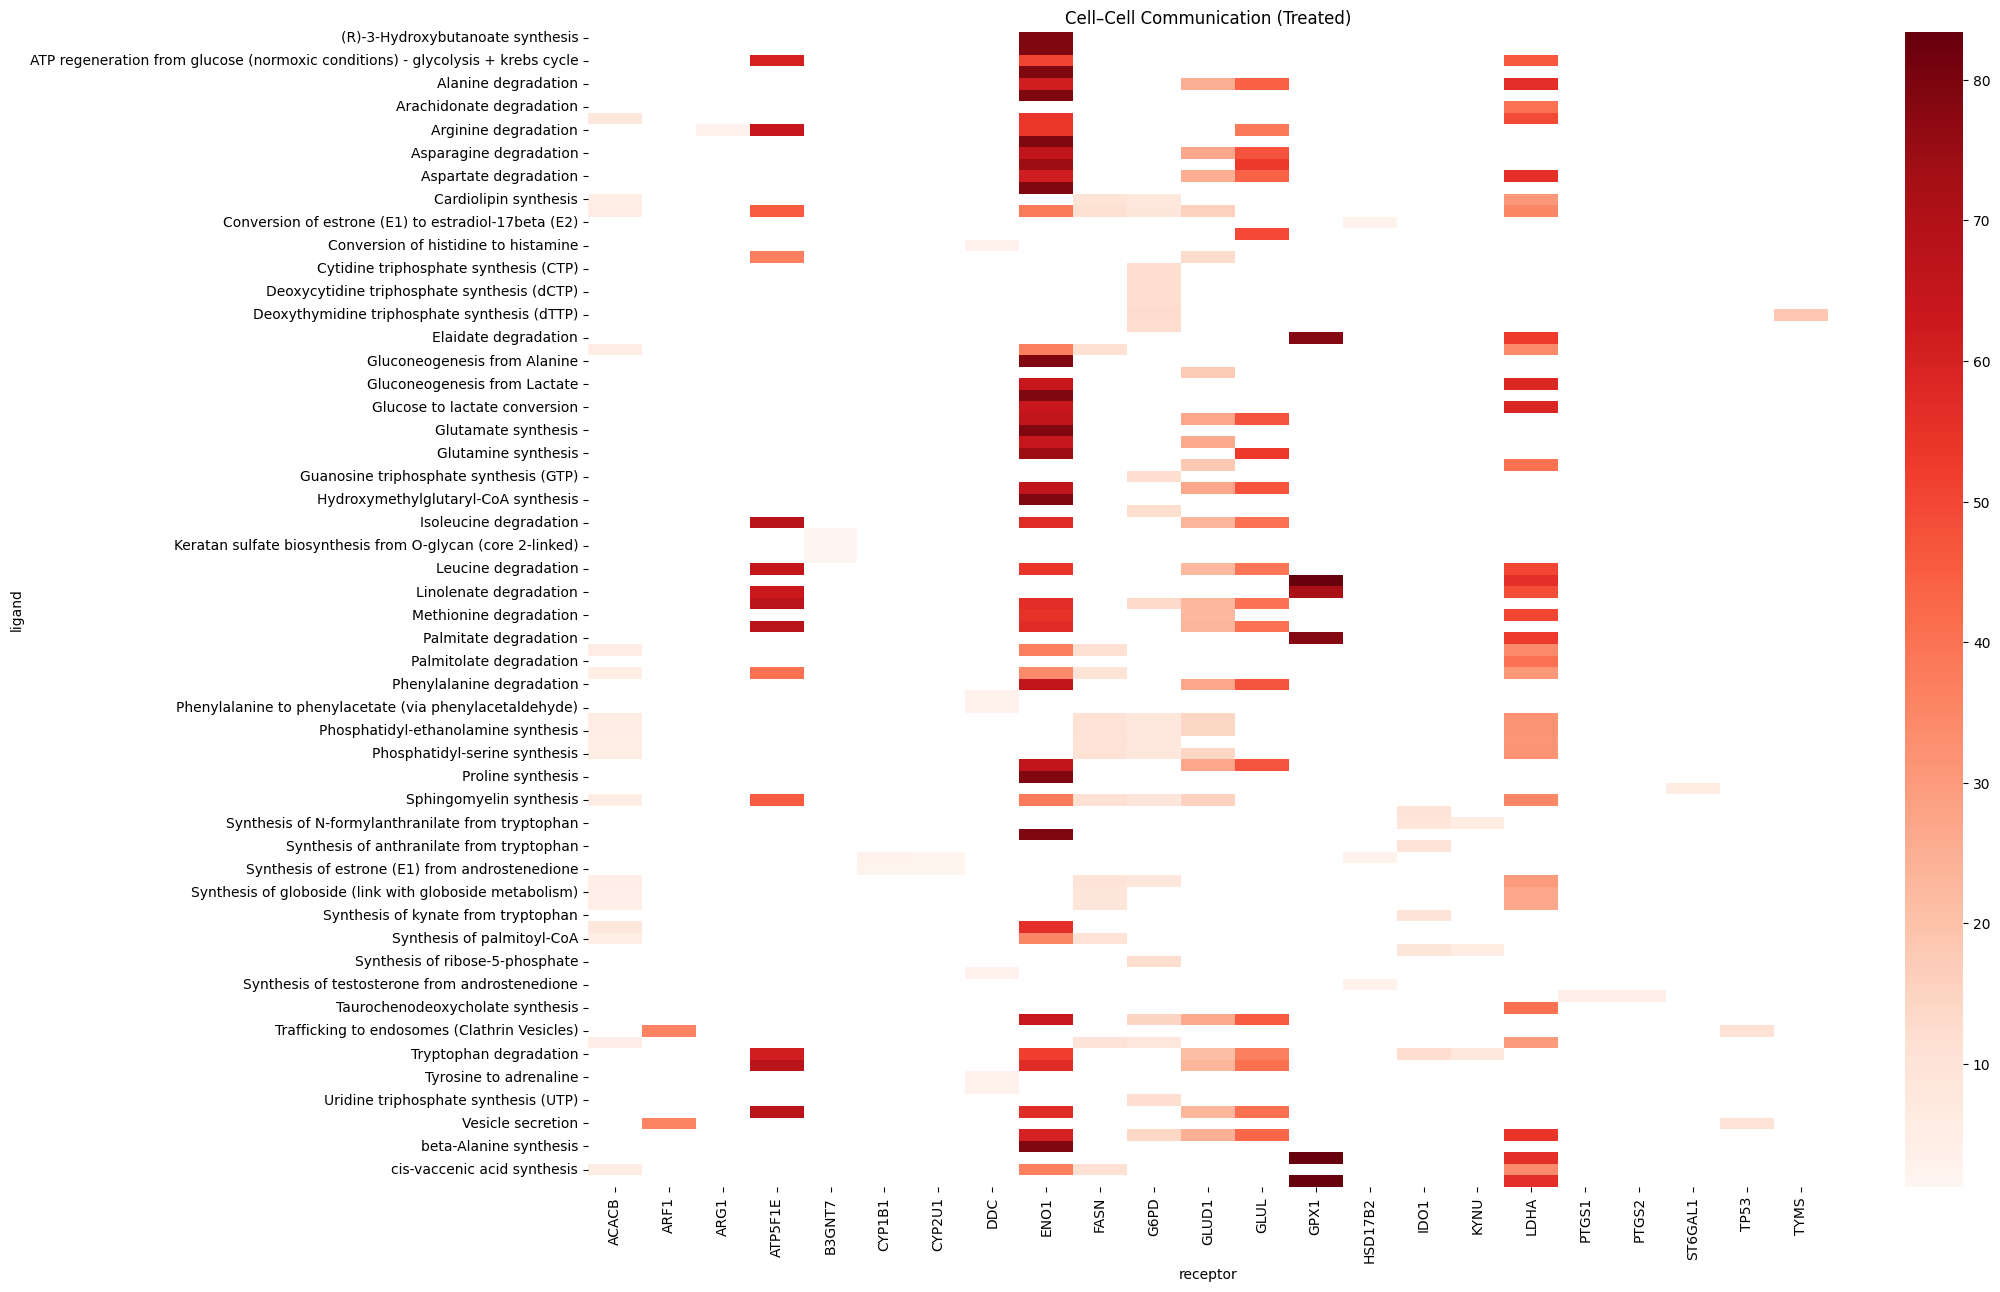

In [23]:
pivot_treated = ccc_adata_treated.pivot_table(index="ligand", columns="receptor", values="score")
plt.figure(figsize=(20,15))
sns.heatmap(pivot_treated, cmap="Reds", annot=False)
plt.title("Cell–Cell Communication (Treated)")
plt.show()

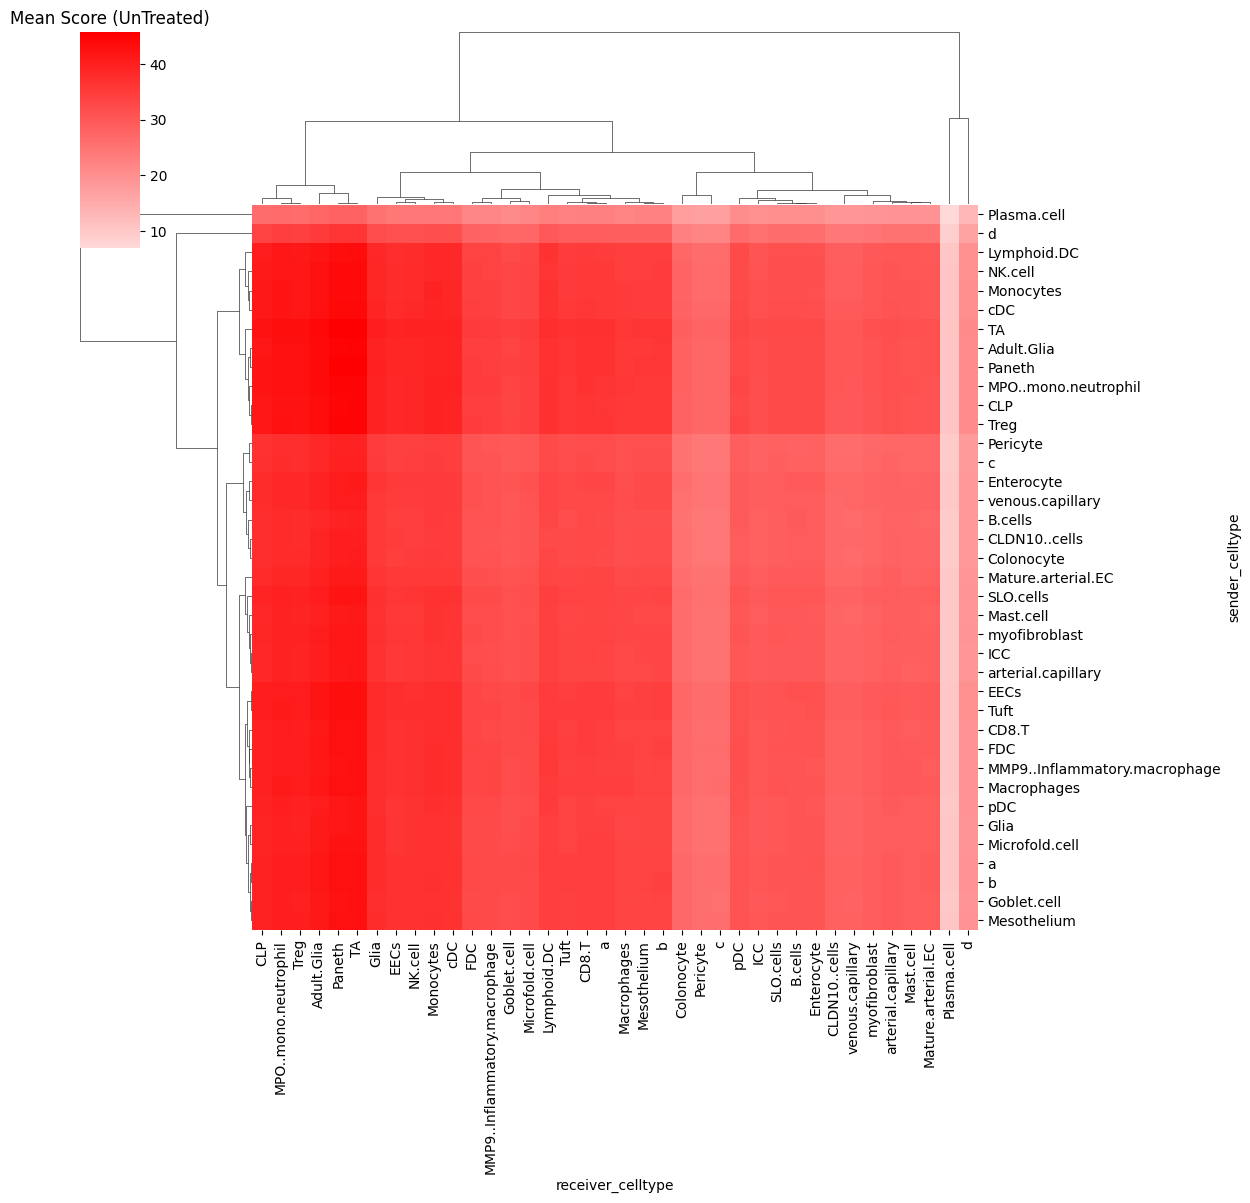

In [24]:
tmp = ccc_adata_untreated.groupby(["sender_celltype", "receiver_celltype"])["score"].mean().reset_index()

pivot = tmp.pivot(index="sender_celltype", columns="receiver_celltype", values="score")

sns.clustermap(
    pivot,
    cmap="bwr",
    center=0,
    annot=False,
    figsize=(12, 12)
)

plt.title("Mean Score (UnTreated)")
plt.show()

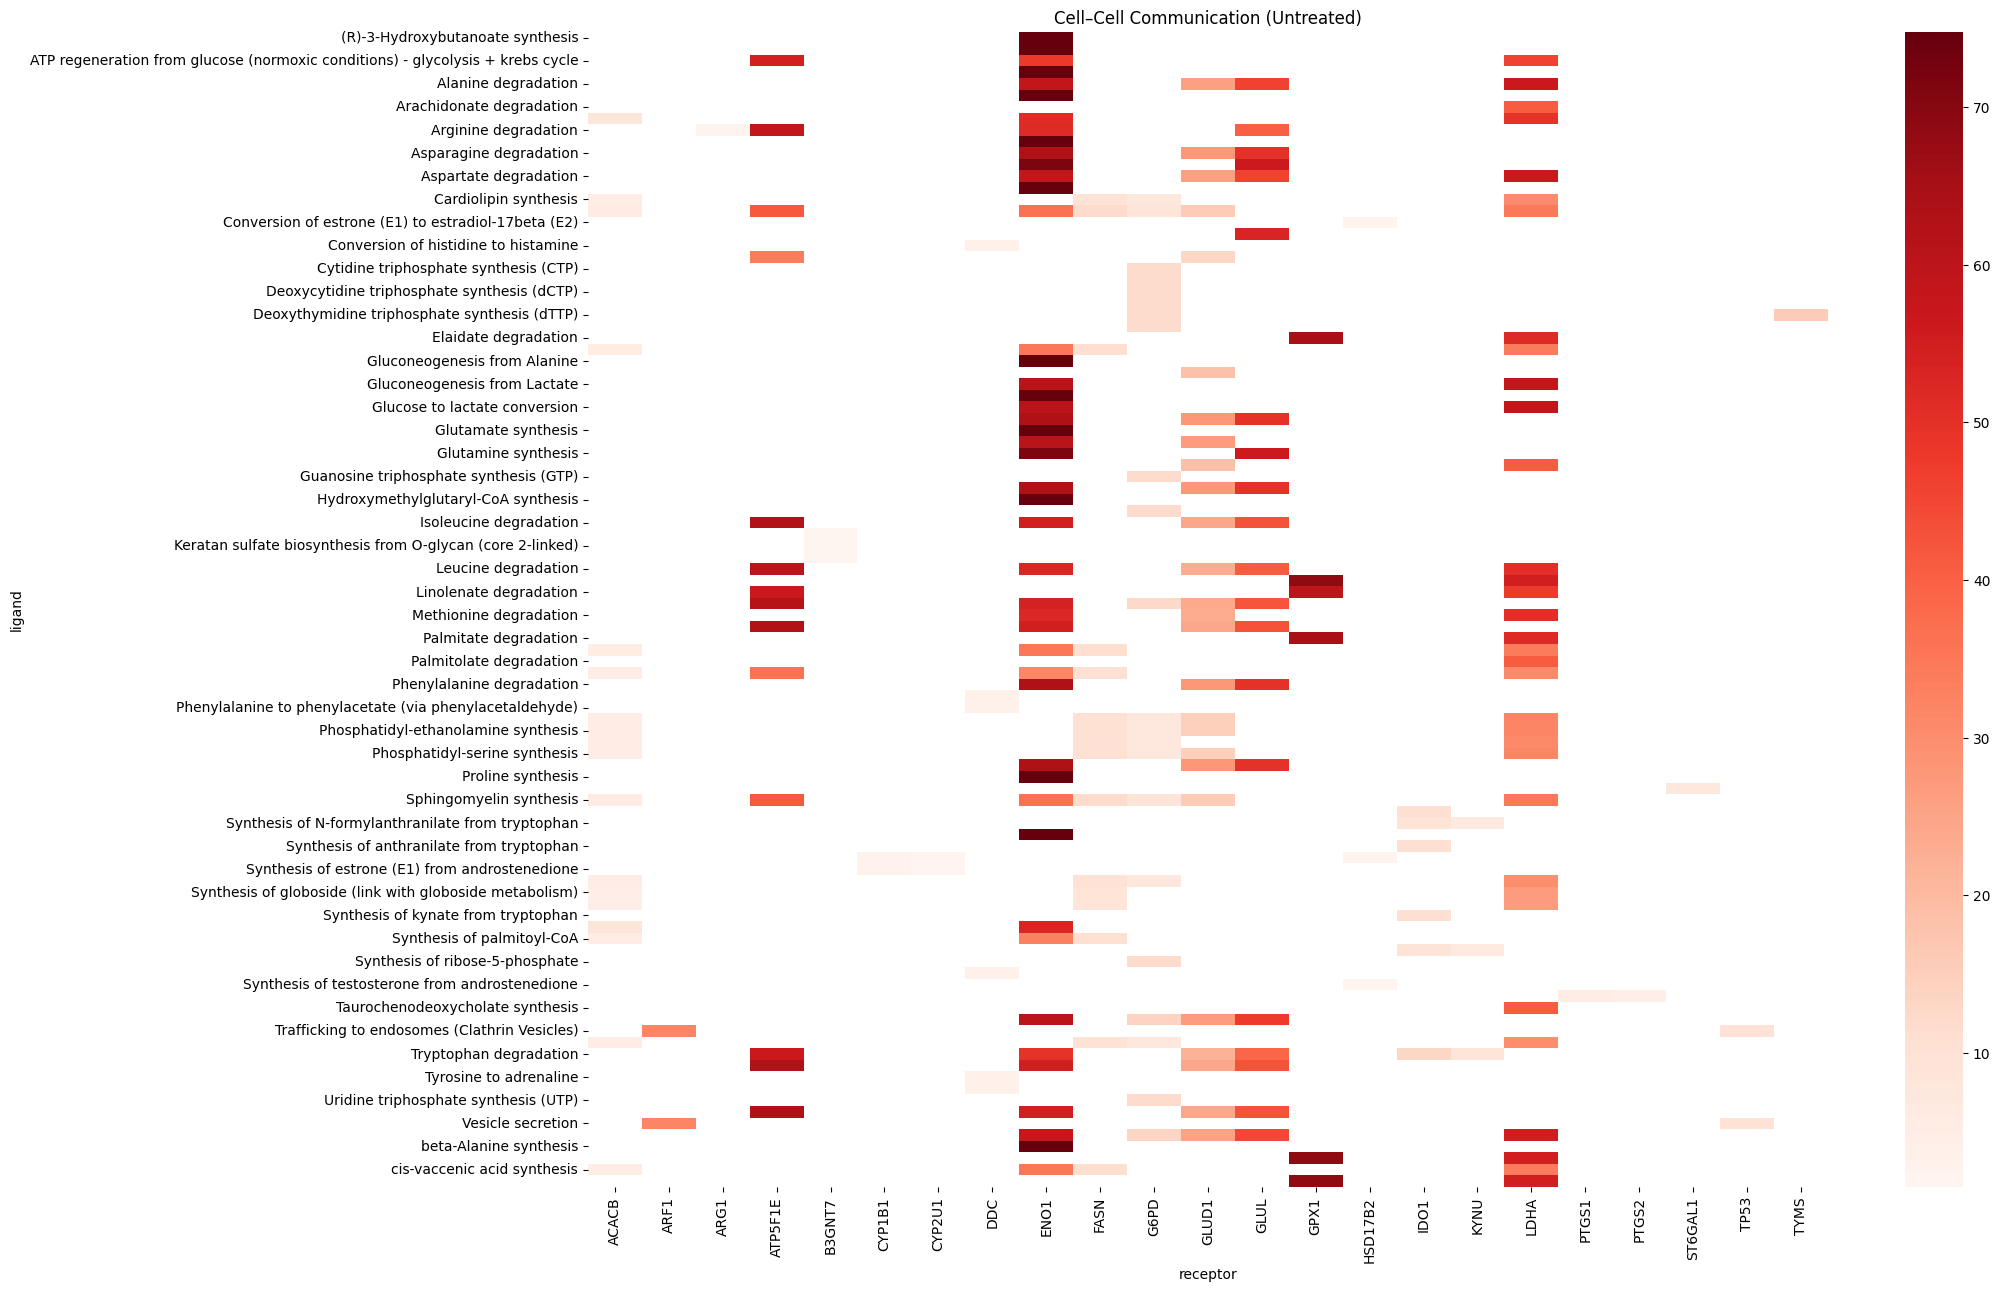

In [25]:
pivot_untreated = ccc_adata_untreated.pivot_table(index="ligand", columns="receptor", values="score")
plt.figure(figsize=(20,15))
sns.heatmap(pivot_untreated, cmap="Reds", annot=False)
plt.title("Cell–Cell Communication (Untreated)")
plt.show()

#### Merged Treated and Untreated Visualization

In [26]:
ccc_t = ccc_adata_treated[["sender_celltype", "receiver_celltype", "ligand", "receptor", "score"]].copy()
ccc_t = ccc_t.rename(columns={"score": "score_treated"})

ccc_u = ccc_adata_untreated[["sender_celltype", "receiver_celltype", "ligand", "receptor", "score"]].copy()
ccc_u = ccc_u.rename(columns={"score": "score_untreated"})

ccc_merge = ccc_t.merge(
    ccc_u,
    on=["sender_celltype", "receiver_celltype", "ligand", "receptor"],
    how="inner" 
)

ccc_merge["diff"] = ccc_merge["score_treated"] - ccc_merge["score_untreated"]

# add pseudocount to avoid log(0)
pseudocount = 1e-6  
ccc_merge["logFC"] = np.log2((ccc_merge["score_treated"] + pseudocount) /
                             (ccc_merge["score_untreated"] + pseudocount))


ccc_merge.head()


,sender_celltype,receiver_celltype,ligand,receptor,score_treated,score_untreated,diff,logFC
0,Adult.Glia,Adult.Glia,(R)-3-Hydroxybutanoate synthesis,ENO1,93.227896,111.662446,-18.434550,-0.260310
1,Adult.Glia,Adult.Glia,ATP generation from glucose (hypoxic condition...,ENO1,93.227896,111.662446,-18.434550,-0.260310
2,Adult.Glia,Adult.Glia,ATP regeneration from glucose (normoxic condit...,LDHA,65.047241,77.010981,-11.963740,-0.243576
3,Adult.Glia,Adult.Glia,ATP regeneration from glucose (normoxic condit...,ENO1,60.350403,71.946590,-11.596187,-0.253563
4,Adult.Glia,Adult.Glia,ATP regeneration from glucose (normoxic condit...,ATP5F1E,59.800456,56.872125,2.928330,0.072435


In [27]:
top_n = int(len(ccc_merge) * 0.1)
ccc_top = ccc_merge.reindex(ccc_merge["logFC"].abs().sort_values(ascending=False).index).head(top_n)
ccc_top

,sender_celltype,receiver_celltype,ligand,receptor,score_treated,score_untreated,diff,logFC
184332,Monocytes,NK.cell,Arginine degradation,ARG1,3.428130,0.000000,3.428130,21.708991
182208,Monocytes,Lymphoid.DC,Arginine degradation,ARG1,0.000000,3.416732,-3.416732,-21.704186
179612,Monocytes,B.cells,Arginine degradation,ARG1,3.384790,0.000000,3.384790,21.690635
121556,MMP9..Inflammatory.macrophage,NK.cell,Arginine degradation,ARG1,3.370257,0.000000,3.370257,21.684427
300916,cDC,NK.cell,Arginine degradation,ARG1,3.359261,0.000000,3.359261,21.679713
...,...,...,...,...,...,...,...,...
58571,EECs,Monocytes,Conversion of histidine to histamine,DDC,3.321587,1.956765,1.364822,0.763402
58654,EECs,Monocytes,Phenylalanine to phenylacetaldehyde,DDC,3.321587,1.956765,1.364822,0.763402
58716,EECs,Monocytes,Synthesis of serotonin from tryptophan,DDC,3.321587,1.956765,1.364822,0.763402
58741,EECs,Monocytes,Tyrosine to adrenaline,DDC,3.321587,1.956765,1.364822,0.763402


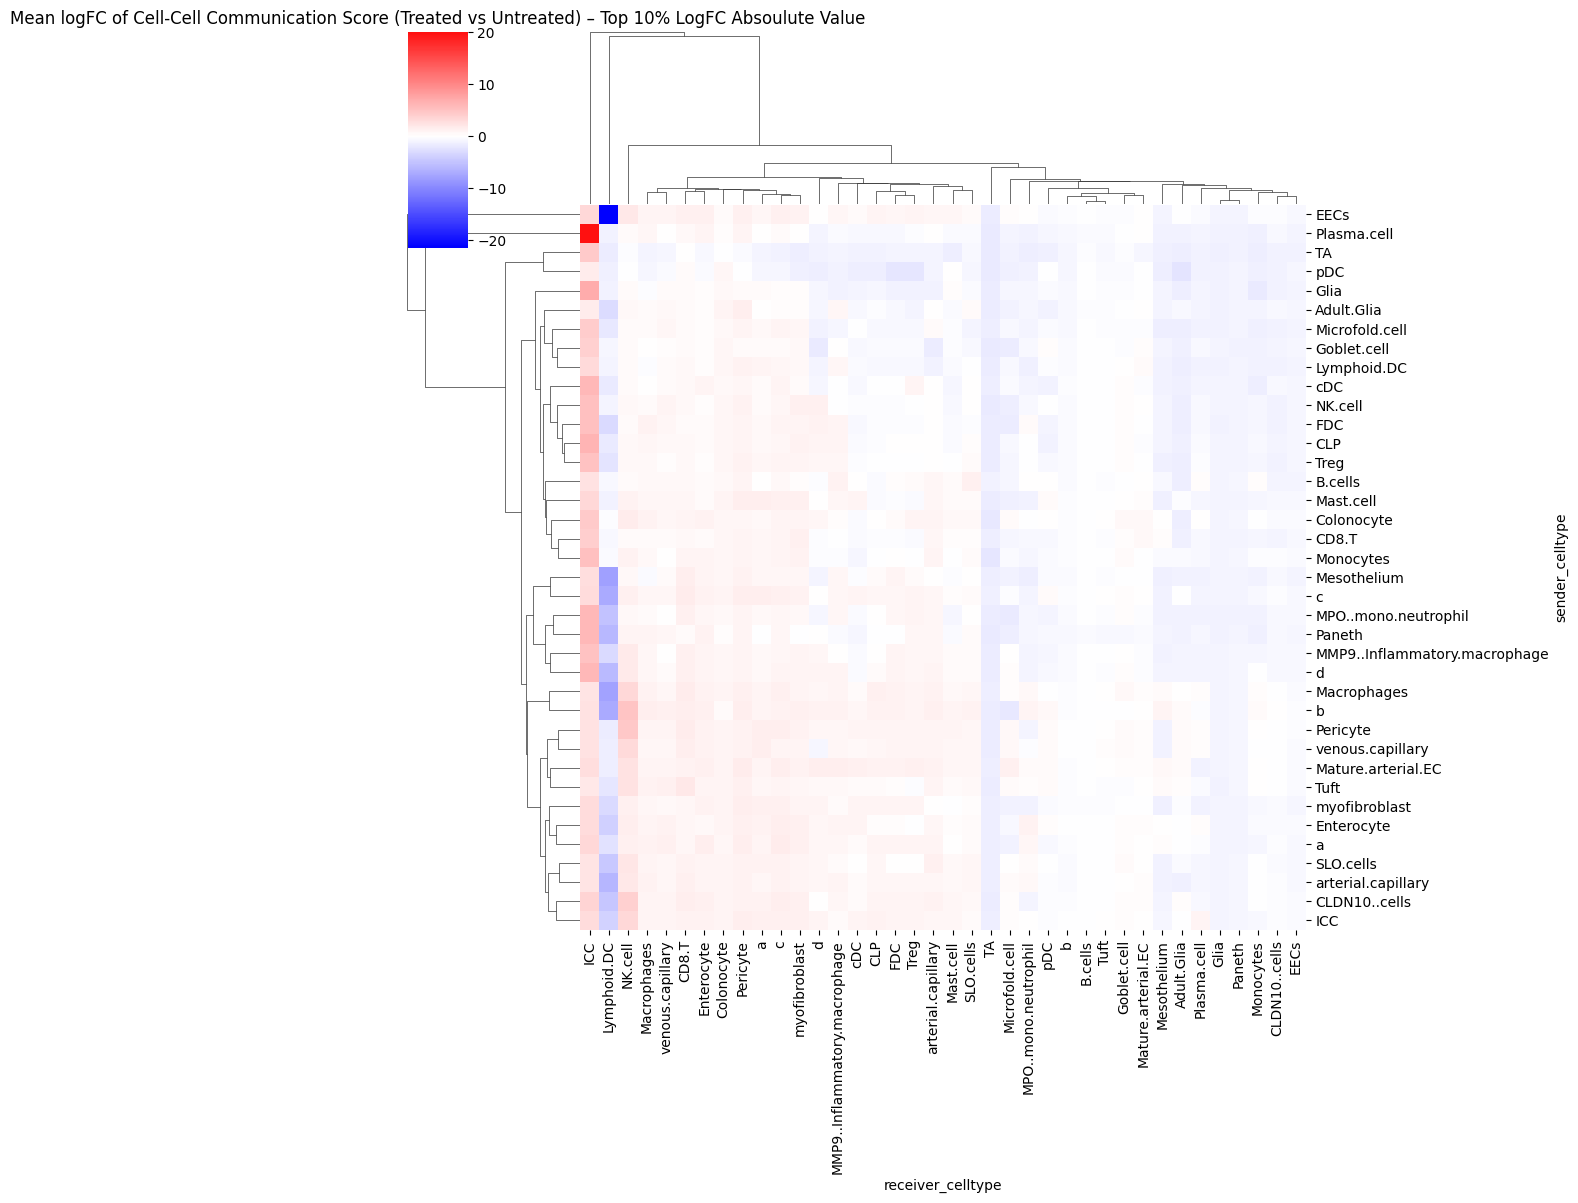

In [32]:
tmp = ccc_top.groupby(["sender_celltype", "receiver_celltype"])["logFC"].mean().reset_index()

pivot = tmp.pivot(index="sender_celltype", columns="receiver_celltype", values="logFC")
pivot = pivot.replace([np.inf, -np.inf], np.nan).fillna(0)

sns.clustermap(
    pivot,
    cmap="bwr",     # red = enriched in treated, blue = enriched in untreated
    center=0,
    annot=False,
    figsize=(12, 12)
)

plt.title("Mean logFC of Cell-Cell Communication Score (Treated vs Untreated) – Top 10% LogFC Absoulute Value")
plt.show()


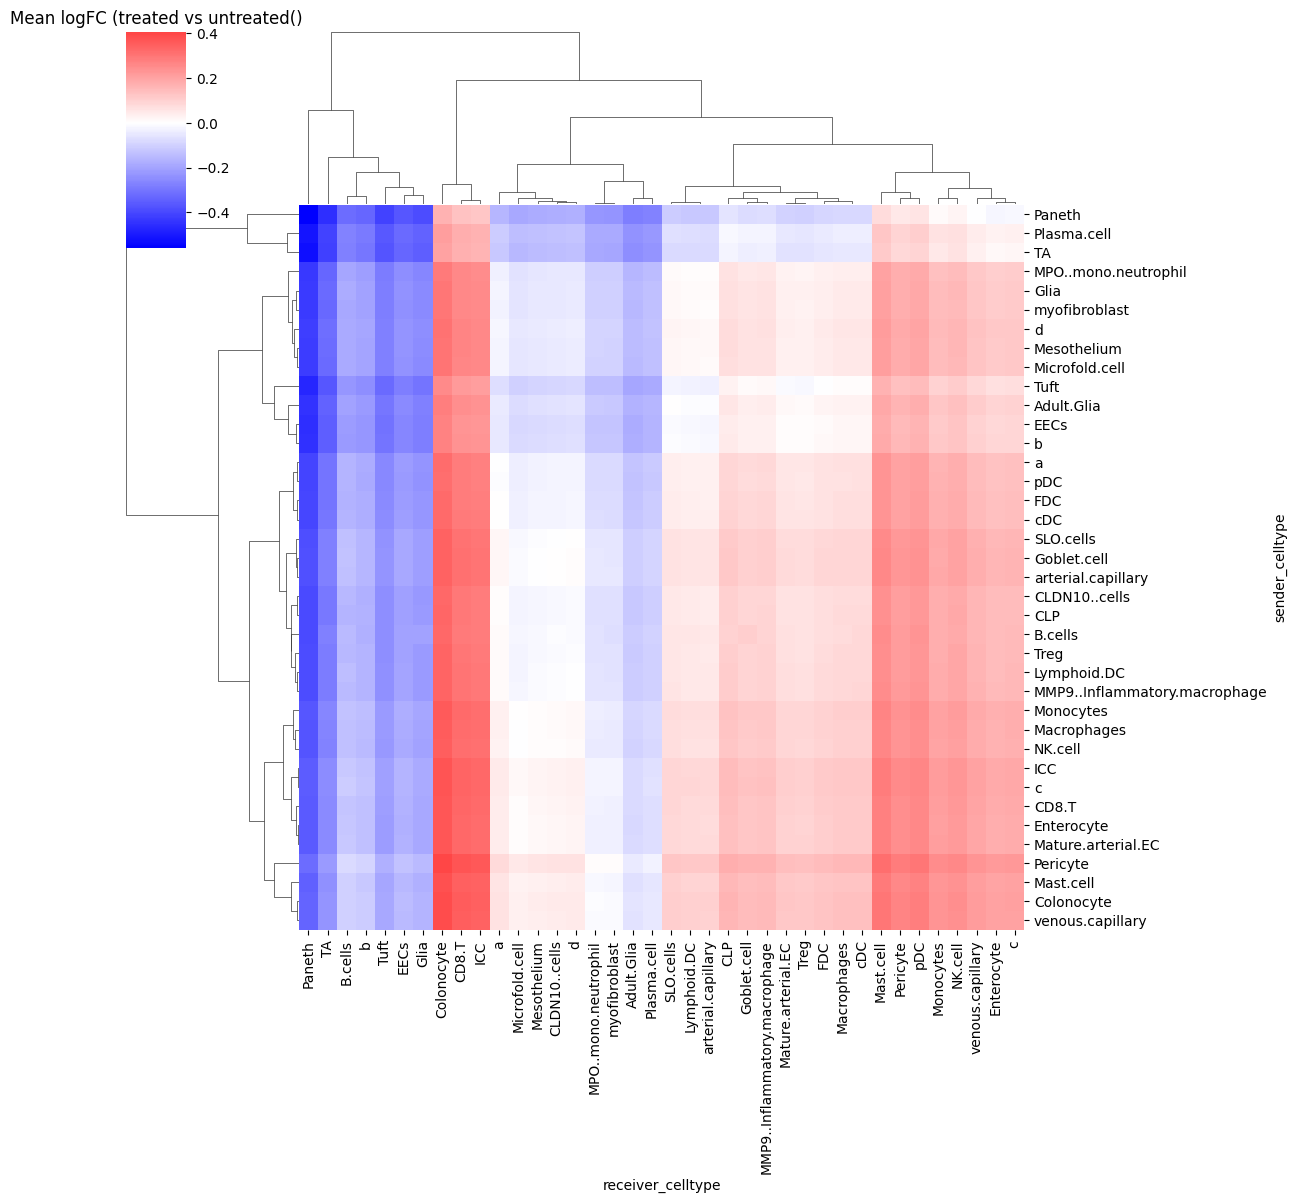

In [30]:
tmp = ccc_merge.groupby(["sender_celltype", "receiver_celltype"])["logFC"].mean().reset_index()

pivot = tmp.pivot(index="sender_celltype", columns="receiver_celltype", values="logFC")
pivot = pivot.replace([np.inf, -np.inf], np.nan).fillna(0)

sns.clustermap(
    pivot,
    cmap="bwr",     # red = enriched in treated, blue = enriched in untreated
    center=0,
    annot=False,
    figsize=(12, 12)
)

plt.title("Mean logFC (treated vs untreated()")
plt.show()


In [ ]:
fig, axs = plt.subplots(len(lr_pairs),1,figsize = (6, 6 * len(lr_pairs)))

axes = axs.flatten()

for i, lr in enumerate(lr_pairs):
    df = ccc_adata_treated.loc[(ccc_adata_treated.ligand == lr[0]) & (ccc_adata_treated.receptor == lr[1])]

    # THRESHOLD FOR IMPORTANT COMMUNICATION SCORE IS MEAN + 1 STD
    score_thresh = df.score.mean() + df.score.std()

    # CELL TYPES MUST EXPRESS LIGAND AND RECEPTOR IN MORE THAN 10% OF SINGLE CELLS
    frac_thresh = (df.ligand_fraction > 0.1) & (df.receptor_fraction > 0.1)

    # FILTER INTERACTONS
    filtered_df = df.loc[(df.score >= score_thresh) & (frac_thresh)]

    # INCLUDE SPECIFIC CELL TYPES
    filtered_df = filtered_df.loc[(filtered_df.sender_celltype.isin(cell_type)) \
                                  & (filtered_df.receiver_celltype.isin(cell_type))]

    # PLOT INTERACTIONS
    ax = axes[i]
    sccellfie.plotting.plot_communication_network(filtered_df,
                                                  'sender_celltype',
                                                  'receiver_celltype',
                                                  'score',
                                                  panel_size=(6,6),
                                                  network_layout='circular',
                                                  edge_color='magenta',
                                                  edge_width=8,
                                                  edge_arrow_size=12,
                                                  edge_alpha=0.25,
                                                  node_color='#210070',
                                                  node_size=500,
                                                  node_alpha=0.75,
                                                  node_label_size=10,
                                                  node_label_alpha=0.7,
                                                  node_label_offset=(0.05, -0.2),
                                                  title=lr_names[i],
                                                  title_fontsize=20,
                                                  tight_layout=True,
                                                  ax=ax
                                                 )